## Import Libraries
Loading all libraries to be used

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sachin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation
## Load data
Lets load the data from _dsjVoxArticles.tsv_ file. We will clean the title to remove special characters and punctuations. We will store title in _titles_ and Category in _categories_

In [2]:
titles = []
categories = []
with open('dsjVoxArticles.tsv','r') as tsv:
    count = 0;
    for line in tsv:
        a = line.strip().split('\t')[:3]
        if a[2] in ['Business & Finance', 'Health Care', 'Science & Health', 'Politics & Policy', 'Criminal Justice']:
            title = a[0].lower()
            title = re.sub('\s\W',' ',title)
            title = re.sub('\W\s',' ',title)
            titles.append(title)
            categories.append(a[2])

We can print and check the data loaded in _titles_ and _categories_

In [3]:
print("Titles-\n", "\n".join(titles[:5]))
print("\nCategories-\n", "\n".join(categories[:5]))

Titles-
 bitcoin is down 60 percent this year here's why i'm still optimistic.
9 charts that explain the history of global wealth
remember when legal marijuana was going to send crime skyrocketing?
obamacare succeeded for one simple reason it's horrible to be uninsured
the best obamacare data comes from a home office in michigan

Categories-
 Business & Finance
Business & Finance
Criminal Justice
Health Care
Health Care


## Split data
Split data into 3 parts - training, development and test. We will use training data to train out model and use development data to check and tune hyper parameters. And finally use test data to see how our model performs

In [4]:
title_tr, title_te, category_tr, category_te = train_test_split(titles,categories)
title_tr, title_de, category_tr, category_de = train_test_split(title_tr,category_tr)
print("Training: ",len(title_tr))
print("Developement: ",len(title_de),)
print("Testing: ",len(title_te))

Training:  1779
Developement:  594
Testing:  792


Using wordCload we can visualize our data.

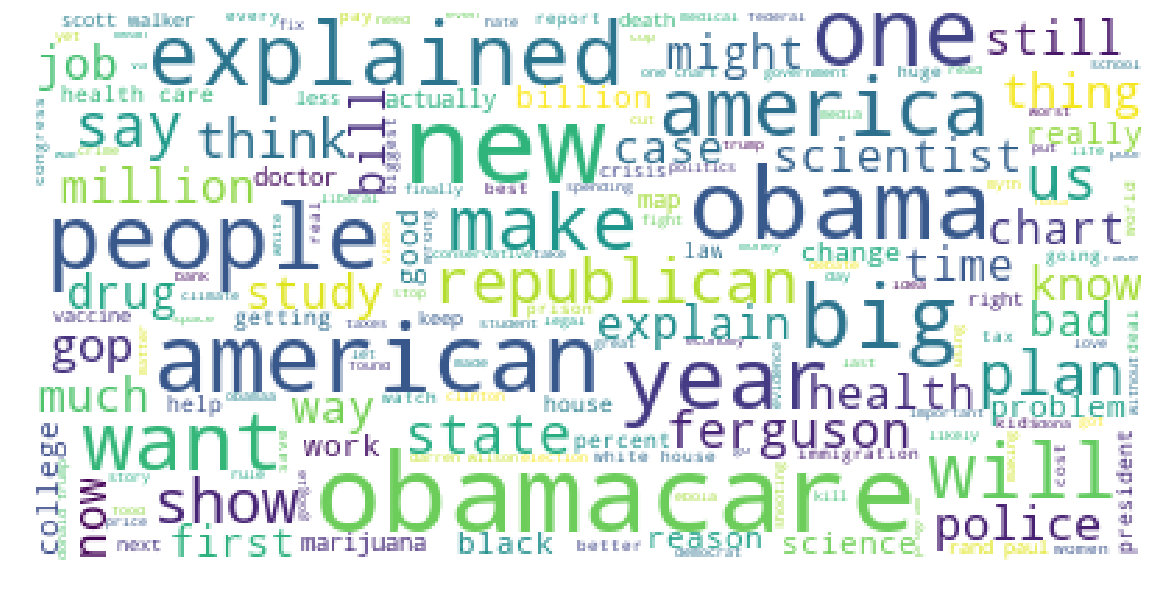

In [5]:
from wordcloud import WordCloud
text = " ".join(title_tr)
wordcloud = WordCloud().generate(text)
plt.figure()
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(text),
    max_font_size=40,
    relative_scaling=.5).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Data Preprocessing
## Vectorization of data
Vectorize the data using Bag of words (BOW)

In [6]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

vectorizer.fit(iter(title_tr))
Xtr = vectorizer.transform(iter(title_tr))
Xde = vectorizer.transform(iter(title_de))
Xte = vectorizer.transform(iter(title_te))

encoder = LabelEncoder()
encoder.fit(category_tr)
Ytr = encoder.transform(category_tr)
Yde = encoder.transform(category_de)
Yte = encoder.transform(category_te)

Lets look at what exactly is this vectorizer doing. We will first create reverse dictionary from the vectorizer. Iterating over the vectorized sentence _Nasa scientists are good_. We get the vector to be representative of three words "good", "nasa" and "scientists". The order has been changed because bag of words does not preserve order.

In [7]:
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word

vector = vectorizer.transform(iter(['Nasa scientists are good']))
indexes = vector.indices
for i in indexes:
    print (reverse_vocabulary[i])

good
nasa
scientists


## Feature Reduction
We can check the variance of the feature and drop them based on a threshold

In [8]:
print("Number of features before reduction : ", Xtr.shape[1])
selection = VarianceThreshold(threshold=0.001)
Xtr_whole = copy.deepcopy(Xtr)
Ytr_whole = copy.deepcopy(Ytr)
selection.fit(Xtr)
Xtr = selection.transform(Xtr)
Xde = selection.transform(Xde)
Xte = selection.transform(Xte)
print("Number of features after reduction : ", Xtr.shape[1])

Number of features before reduction :  4330
Number of features after reduction :  1790


## Sampling data
We will count the number of diffrent labels in dataset and plot a pie chart distribution.

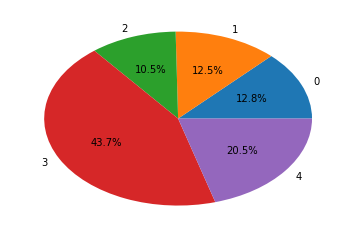

In [9]:
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

As we can see the class labels are not uniformy distributed so we will use SMOT and oversample the classes which are less in number so that classes are equally distributed

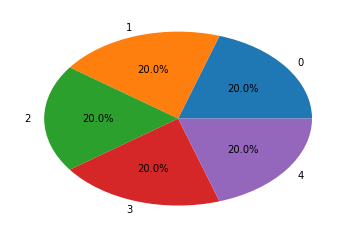

In [10]:
sm = SMOTE(random_state=42)
Xtr, Ytr = sm.fit_sample(Xtr, Ytr)
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

# Train Models
### Baseline Model
“stratified”: generates predictions by respecting the training set’s class distribution.

In [11]:
dc = DummyClassifier(strategy="stratified")
dc.fit(Xtr, Ytr)
pred = dc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.20      0.24      0.21        93
  Criminal Justice       0.10      0.18      0.13        74
       Health Care       0.11      0.24      0.15        51
 Politics & Policy       0.35      0.16      0.22       240
  Science & Health       0.18      0.18      0.18       136

       avg / total       0.23      0.18      0.19       594



### Decision Tree

In [12]:
dt = DecisionTreeClassifier()
dt.fit(Xtr, Ytr)
pred = dt.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.53      0.49      0.51        93
  Criminal Justice       0.52      0.46      0.49        74
       Health Care       0.51      0.53      0.52        51
 Politics & Policy       0.64      0.62      0.63       240
  Science & Health       0.54      0.61      0.57       136

       avg / total       0.57      0.57      0.57       594



### Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=40)
rf.fit(Xtr, Ytr)
pred = rf.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.55      0.43      0.48        93
  Criminal Justice       0.57      0.39      0.46        74
       Health Care       0.48      0.61      0.53        51
 Politics & Policy       0.66      0.63      0.65       240
  Science & Health       0.51      0.65      0.57       136

       avg / total       0.58      0.57      0.57       594



### Multinomial Naive Bayesian

In [14]:
nb = MultinomialNB()
nb.fit(Xtr, Ytr)
pred = nb.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.58      0.60      0.59        93
  Criminal Justice       0.55      0.54      0.54        74
       Health Care       0.45      0.65      0.53        51
 Politics & Policy       0.71      0.67      0.69       240
  Science & Health       0.66      0.61      0.63       136

       avg / total       0.64      0.63      0.63       594



### Support Vector Classification

In [15]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(Xtr, Ytr)
pred = svc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.23      0.92      0.37        93
  Criminal Justice       1.00      0.12      0.22        74
       Health Care       0.57      0.31      0.41        51
 Politics & Policy       0.88      0.25      0.39       240
  Science & Health       0.57      0.51      0.53       136

       avg / total       0.70      0.41      0.40       594



### Multilayered Perceptron

In [16]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), random_state=1, max_iter=400)
mlp.fit(Xtr, Ytr)
pred = mlp.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.52      0.54      0.53        93
  Criminal Justice       0.60      0.43      0.50        74
       Health Care       0.50      0.59      0.54        51
 Politics & Policy       0.66      0.71      0.69       240
  Science & Health       0.64      0.60      0.62       136

       avg / total       0.61      0.61      0.61       594



# Final Model: Multinomial Naive Bayesian
**Multinomial Naive Bayesian** works the best. Lets run NB on our test data and get the confusion matrix and its heat map.
## Predict test data

                    precision    recall  f1-score   support

Business & Finance       0.48      0.50      0.49       105
  Criminal Justice       0.57      0.58      0.57       111
       Health Care       0.51      0.70      0.59        89
 Politics & Policy       0.74      0.63      0.68       341
  Science & Health       0.62      0.67      0.64       146

       avg / total       0.64      0.62      0.62       792



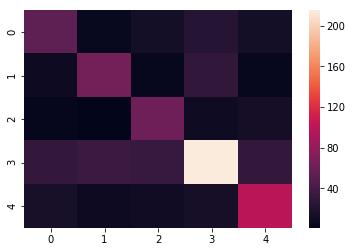

In [17]:
pred = nb.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(Yte, pred))

## Multinomial Naive Bayesian Explained
We will now try to understand why Naive Bayesian is getting good results. We will get all the coefficents of the features and then print the top 20 words based on its weight. As we can see all the words are closely related to the category, hence multinomial naive bayesian predcits correct label with good F1 score.

In [18]:
nb1 = MultinomialNB()
nb1.fit(Xtr_whole, Ytr_whole)
coefs = nb1.coef_
target_names = encoder.classes_

for i in range(len(target_names)):
    words = []
    for j in coefs[i].argsort()[-20:]:
        words.append(reverse_vocabulary[j])
    print (target_names[i], '-', words, "\n")

Business & Finance - ['world', 'every', 'america', 'chart', '000', 'apple', 'plan', 'one', 'deal', 'explained', 'us', 'greek', 'big', 'google', 'crisis', 'â', 'economy', 'people', 'could', 'new'] 

Criminal Justice - ['â', 'justice', 'jury', 'explained', 'shot', 'chart', 'grand', 'eric', 'war', 'new', 'people', 'michael', 'black', 'one', 'brown', 'darren', 'wilson', 'marijuana', 'police', 'ferguson'] 

Health Care - ['birth', 'america', 'million', 'us', 'control', 'study', 'people', 'uninsured', 'doctors', 'â', 'year', 'could', 'new', 'one', 'medicaid', '000', 'care', 'va', 'health', 'obamacare'] 

Politics & Policy - ['paul', '2016', 'republicans', 'clinton', 'walker', 'trump', 'people', 'america', 'big', 'explained', 'president', 'new', 'gop', 'house', 'debate', 'republican', 'one', 'â', 'obamacare', 'obama'] 

Science & Health - ['cancer', 'could', 'dr', 'food', 'know', 'might', 'pluto', 'year', 'us', 'health', 'think', 'big', 'space', 'people', 'nasa', 'one', 'science', 'scientists